# Student Performance Prediction

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor



#### Read the data

In [2]:
df = pd.read_csv('exams.csv')

#### Prepare the dataset

In [3]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86
...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71
996,male,group C,some college,standard,none,80,66,66
997,female,group A,high school,standard,completed,67,86,86
998,male,group E,high school,standard,none,80,72,62


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [5]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

#### Feature Engineering

In [7]:
pd.cut(df['math_score'], bins=[0, 50, 70, 85, 100]).value_counts().sort_index()

math_score
(0, 50]      131
(50, 70]     428
(70, 85]     322
(85, 100]    119
Name: count, dtype: int64

In [8]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(f'\n{df[col].value_counts()}')


gender
male      508
female    492
Name: count, dtype: int64

race/ethnicity
group C    323
group D    257
group B    198
group E    143
group A     79
Name: count, dtype: int64

parental_level_of_education
some college          224
high school           215
associate's degree    204
some high school      177
bachelor's degree     105
master's degree        75
Name: count, dtype: int64

lunch
standard        660
free/reduced    340
Name: count, dtype: int64

test_preparation_course
none         656
completed    344
Name: count, dtype: int64


In [9]:
label_cols =['gender','race/ethnicity','lunch','test_preparation_course']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])

In [10]:
# Define the order of educational levels
education_order = [
    "some high school",
    "high school",
    "some college",
    "associate's degree",
    "bachelor's degree",
    "master's degree"
]

# Map each level to its rank
education_mapping = {level: rank for rank, level in enumerate(education_order)}

# Apply ordinal encoding
df['parental_level_of_education_encoded'] = df['parental_level_of_education'].map(education_mapping)

# drop the column
df.drop('parental_level_of_education', axis=1, inplace=True)

In [11]:
df.head()

,gender,race/ethnicity,lunch,test_preparation_course,math_score,reading_score,writing_score,parental_level_of_education_encoded
0,0,3,1,0,59,70,78,2
1,1,3,1,1,96,93,87,3
2,0,3,0,1,57,76,77,2
3,1,1,0,1,70,70,63,2
4,0,3,1,1,83,85,86,3


In [12]:
df.describe()

,gender,race/ethnicity,lunch,test_preparation_course,math_score,reading_score,writing_score,parental_level_of_education_encoded
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.508000,2.187000,0.660000,0.656000,67.810000,70.382000,69.140000,2.070000
std,0.500186,1.144264,0.473946,0.475279,15.250196,14.107413,15.025917,1.489738
min,0.000000,0.000000,0.000000,0.000000,15.000000,25.000000,15.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,58.000000,61.000000,59.000000,1.000000
50%,1.000000,2.000000,1.000000,1.000000,68.000000,70.500000,70.000000,2.000000
75%,1.000000,3.000000,1.000000,1.000000,79.250000,80.000000,80.000000,3.000000
max,1.000000,4.000000,1.000000,1.000000,100.000000,100.000000,100.000000,5.000000


In [13]:
df.columns

Index(['gender', 'race/ethnicity', 'lunch', 'test_preparation_course',
       'math_score', 'reading_score', 'writing_score',
       'parental_level_of_education_encoded'],
      dtype='object')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   gender                               1000 non-null   int64
 1   race/ethnicity                       1000 non-null   int64
 2   lunch                                1000 non-null   int64
 3   test_preparation_course              1000 non-null   int64
 4   math_score                           1000 non-null   int64
 5   reading_score                        1000 non-null   int64
 6   writing_score                        1000 non-null   int64
 7   parental_level_of_education_encoded  1000 non-null   int64
dtypes: int64(8)
memory usage: 62.6 KB


#### Exploratory Data Analysis(EDA)

##### Histogram and Boxplot

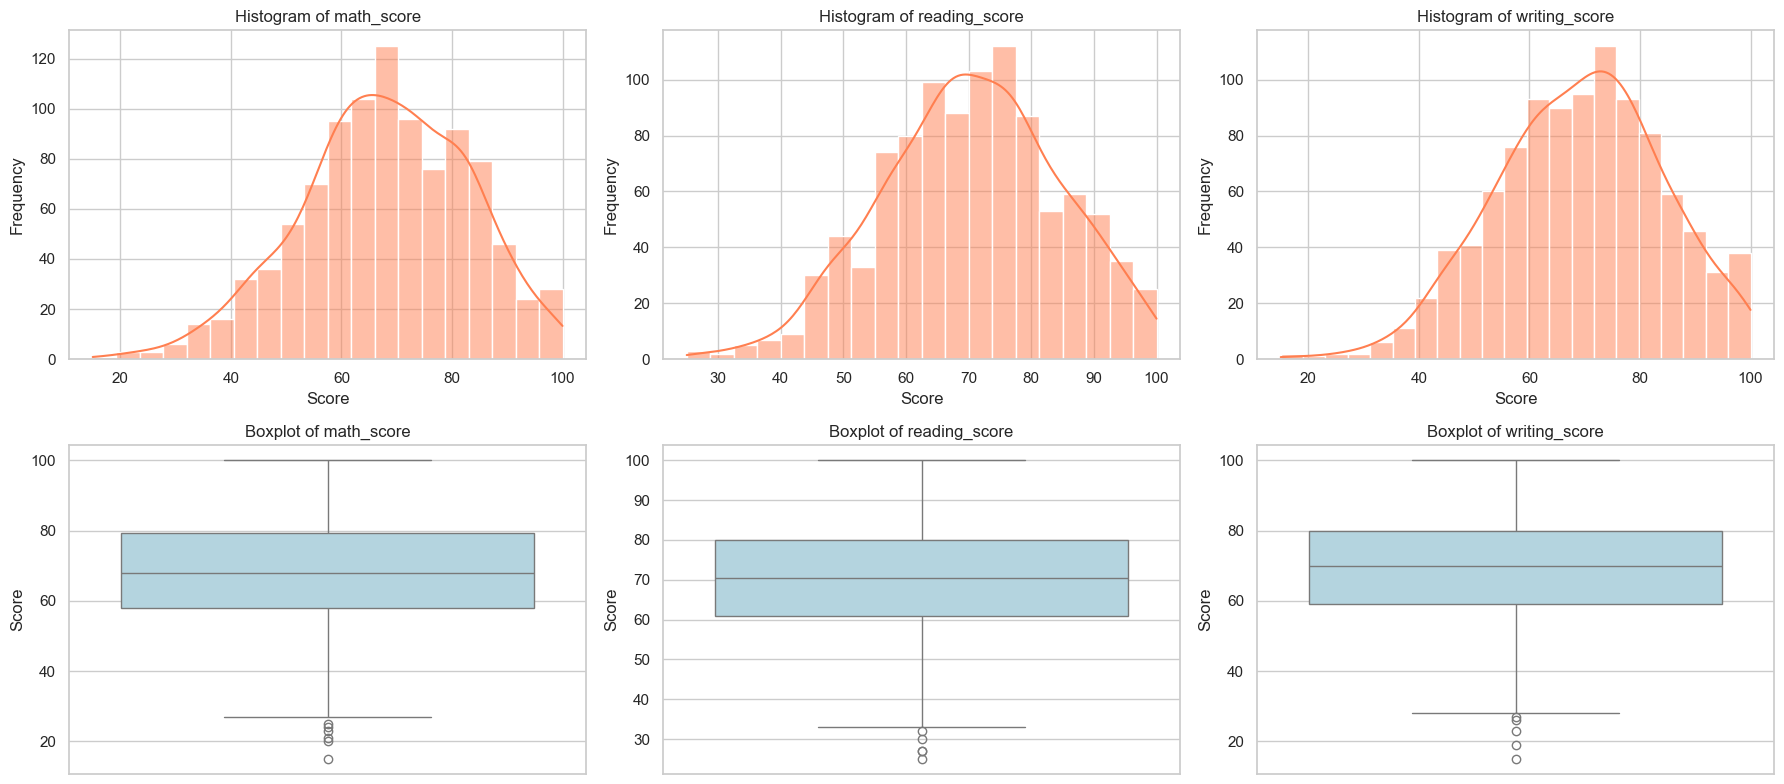

In [15]:
# Set visual style
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))


# Continuous features
num_cols = ['math_score', 'reading_score', 'writing_score']

# Create subplots
for i, col in enumerate(num_cols):
    # Histogram
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, color='coral')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(2, 3, i + 4)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [16]:
# Continuous variables
num_cols = ['math_score', 'reading_score', 'writing_score']

# Calculate skewness and kurtosis
for col in num_cols:
    skew_val = df[col].skew()
    kurtosis_val = df[col].kurt()
    print(f"{col} → Skewness: {skew_val:.2f}, Kurtosis: {kurtosis_val:.2f}")

math_score → Skewness: -0.28, Kurtosis: -0.13
reading_score → Skewness: -0.18, Kurtosis: -0.26
writing_score → Skewness: -0.21, Kurtosis: -0.18


In [17]:
# List of continuous features
num_cols = ['math_score', 'reading_score', 'writing_score']

# Detect and flag outliers using IQR
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers detected") 

math_score: 6 outliers detected
reading_score: 5 outliers detected
writing_score: 5 outliers detected


In [18]:
# Continuous features
num_cols = ['math_score', 'reading_score', 'writing_score']

# IQR-based filtering
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only non-outlier rows
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

print("Outliers removed from continuous variables.")

    

Outliers removed from continuous variables.


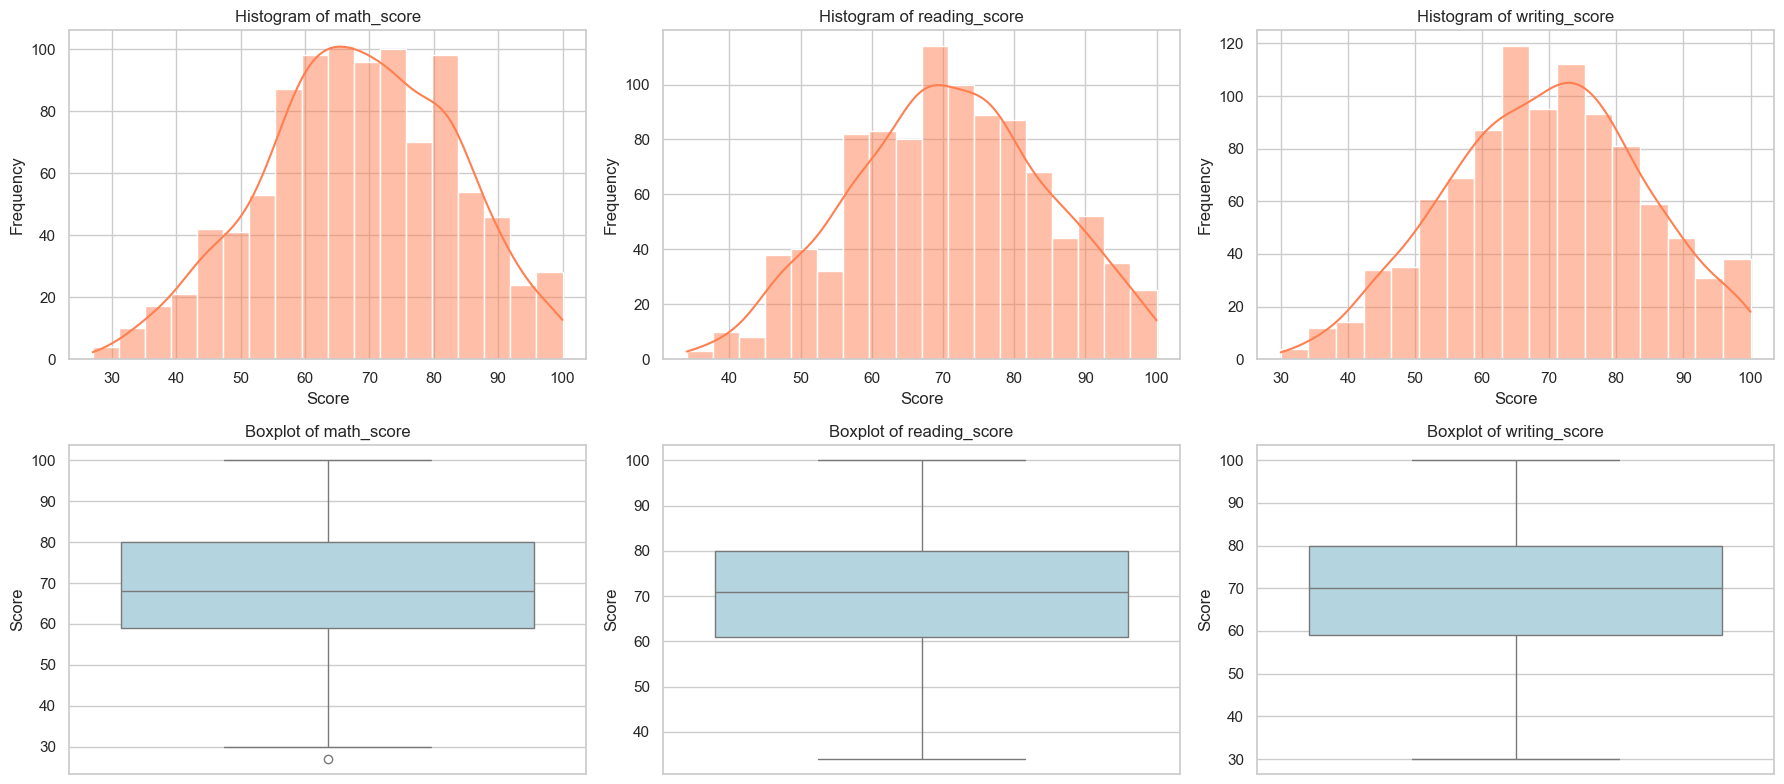

In [19]:
# Set visual style
sns.set(style='whitegrid')
plt.figure(figsize=(18, 8))


# Continuous features
num_cols = ['math_score', 'reading_score', 'writing_score']

# Create subplots
for i, col in enumerate(num_cols):
    # Histogram
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, color='coral')
    plt.title(f'Histogram of {col}')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(2, 3, i + 4)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [20]:
# Continuous variables
num_cols = ['math_score', 'reading_score', 'writing_score']

# Calculate skewness and kurtosis
for col in num_cols:
    skew_val = df[col].skew()
    kurtosis_val = df[col].kurt()
    print(f"{col} → Skewness: {skew_val:.2f}, Kurtosis: {kurtosis_val:.2f}")


# - No need for transformation like log or Box-Cox— our distributions are modeling-ready.


math_score → Skewness: -0.14, Kurtosis: -0.43
reading_score → Skewness: -0.06, Kurtosis: -0.50
writing_score → Skewness: -0.08, Kurtosis: -0.49


##### Heatmap

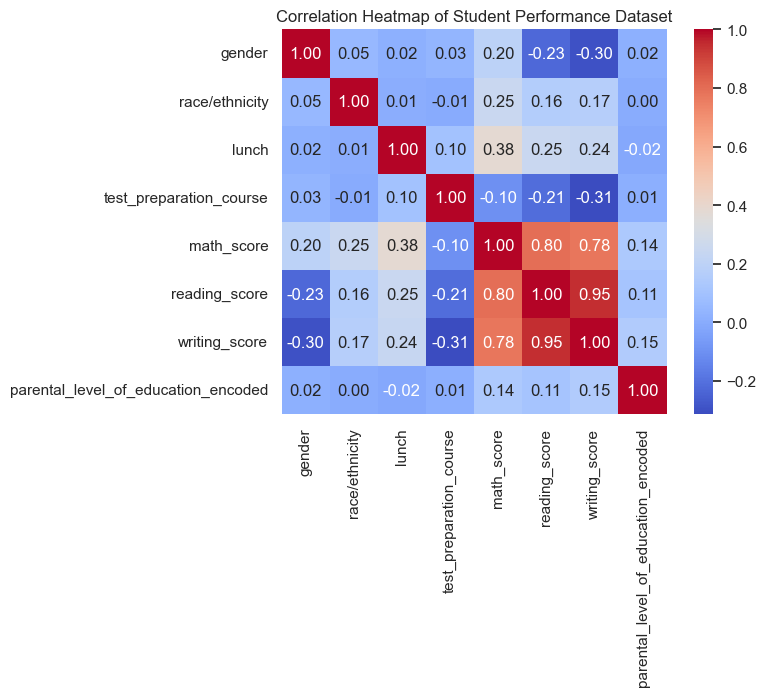

In [21]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap of Student Performance Dataset')
plt.show()


C:\Users\JEEVA\AppData\Local\Temp\ipykernel_20200\241413627.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_math.values, y=corr_with_math.index, palette='coolwarm')


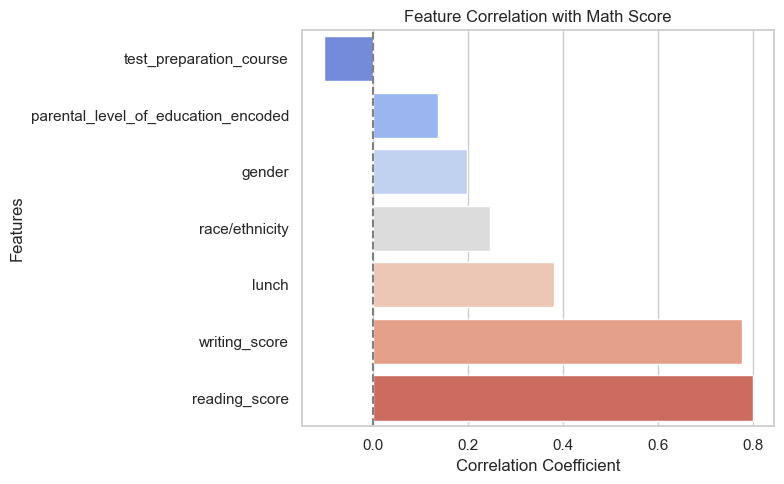

In [55]:
# Compute correlation matrix
corr_matrix = df.corr()

# Extract correlations with math_score and drop self-correlation
corr_with_math = corr_matrix['math_score'].drop('math_score').sort_values()

# Plot as bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=corr_with_math.values, y=corr_with_math.index, palette='coolwarm')
plt.title('Feature Correlation with Math Score')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


In [56]:
# Example mappings
gender_map = {0: 'male', 1: 'female'}
lunch_map = {0: 'free/reduced', 1: 'standard'}
test_prep_map = {0: 'not completed', 1: 'completed'}
education_map = {
    0: 'some high school', 1: 'high school', 2: 'some college',
    3: 'associate\'s degree', 4: 'bachelor\'s degree', 5: 'master\'s degree'
}
race_map = {0: 'group A', 1: 'group B', 2: 'group C', 3: 'group D', 4: 'group E'}

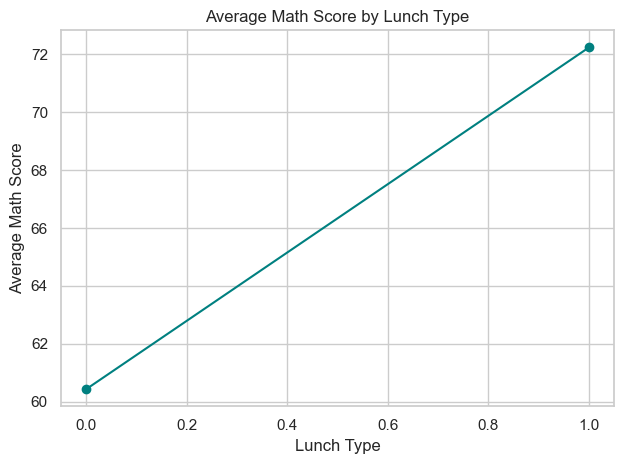

In [57]:
# Grouping and averaging math scores by lunch type
avg_scores = df.groupby('lunch')['math_score'].mean().reset_index()

# Plotting the line plot
plt.plot(avg_scores['lunch'], avg_scores['math_score'], marker='o', linestyle='-', color='teal')

# Formatting
plt.title('Average Math Score by Lunch Type')
plt.xlabel('Lunch Type')
plt.ylabel('Average Math Score')
plt.grid(True)
plt.tight_layout()
plt.show()


the correlation coefficient between math score and reading score is 0.80, and between math score and writing score is 0.78. These are strong positive correlations, meaning students who perform well in reading and writing tend to also score high in math.


##### Scatterplot

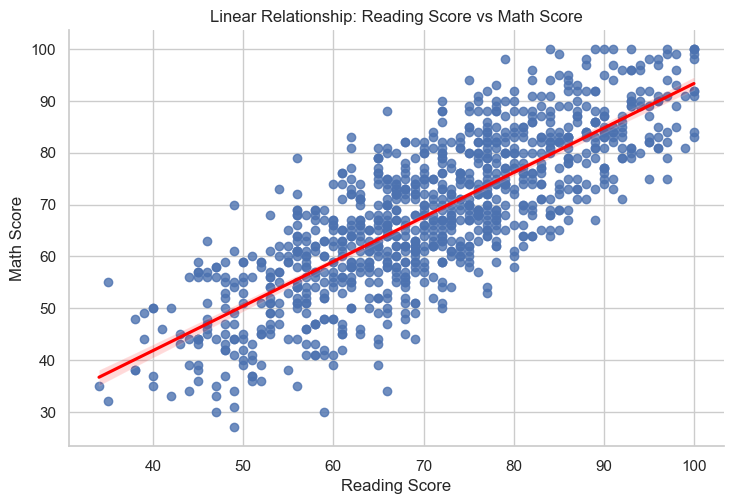

In [58]:
sns.lmplot(x='reading_score', y='math_score', data=df, aspect=1.5, height=5, line_kws={'color': 'red'})
plt.title('Linear Relationship: Reading Score vs Math Score')
plt.xlabel('Reading Score')
plt.ylabel('Math Score')
plt.show()


In [59]:
df.columns

Index(['gender', 'race/ethnicity', 'lunch', 'test_preparation_course',
       'math_score', 'reading_score', 'writing_score',
       'parental_level_of_education_encoded'],
      dtype='object')

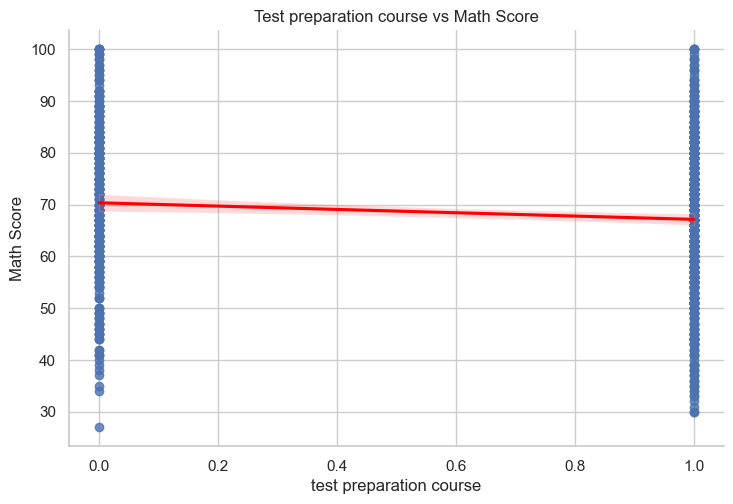

In [60]:
sns.lmplot(x='test_preparation_course', y='math_score', data=df, aspect=1.5, height=5, line_kws={'color': 'red'})
plt.title('Test preparation course vs Math Score')
plt.xlabel('test preparation course')
plt.ylabel('Math Score')
plt.show()

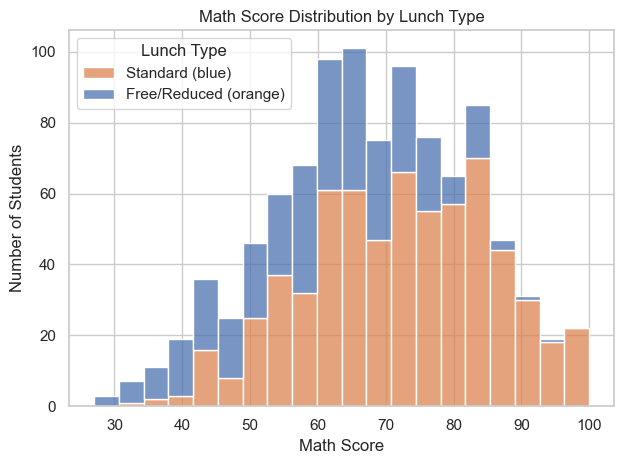

In [61]:
color_map = {'standard': 'green', 'free/reduced': 'orange'}

# Plot the histogram with custom colors
sns.histplot(
    data=df,
    x='math_score',
    hue='lunch',
    bins=20,
    multiple='stack'
)

# Add labels and legend
plt.title('Math Score Distribution by Lunch Type')
plt.xlabel('Math Score')
plt.ylabel('Number of Students')
plt.legend(title='Lunch Type', labels=['Standard (blue)', 'Free/Reduced (orange)'])
plt.tight_layout()
plt.show()


#### Test and Train the data

##### Supervised Learning - Regression

In [62]:

#  Target and features
X = df.drop('math_score', axis=1)
y = df['math_score']

#  Split the data
trainX,testX,trainY,testY = train_test_split(X, y, test_size=0.2, random_state=42)

#  Build the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(trainX, trainY)

# Predict
y_pred = dt_model.predict(testX)


In [63]:
#  Evaluate
rmse = np.sqrt(mean_squared_error(testY, y_pred))
mae = mean_absolute_error(testY, y_pred)
r2 = r2_score(testY, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}") #Most predictions miss by about 6 points — not too bad, but can be tighter
print(f"R²: {r2:.2f}") #70% of math score variation is captured — solid baseline, room for improvement

RMSE: 7.69
MAE: 6.08
R²: 0.70


In [64]:
# Predict on training set
y_train_pred = dt_model.predict(trainX)

# Evaluate training performance
rmse_train = np.sqrt(mean_squared_error(trainY, y_train_pred))
mae_train = mean_absolute_error(trainY, y_train_pred)
r2_train = r2_score(trainY, y_train_pred)

print(f" Training RMSE: {rmse_train:.2f}")
print(f" Training MAE: {mae_train:.2f}")
print(f" Training R²: {r2_train:.2f}")

 Training RMSE: 0.10
 Training MAE: 0.01
 Training R²: 1.00


### XGBRegressor

In [65]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(trainX, trainY)
y_pred_xgb = xgb_model.predict(testX)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(testY, y_pred_xgb))
mae_xgb = mean_absolute_error(testY, y_pred_xgb)
r2_xgb = r2_score(testY, y_pred_xgb)


print(f"XGBoost MAE: {mae_xgb:.2f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.2f}")



#model explains more of the variance in math scores. r^2: 0.79

XGBoost MAE: 5.06
XGBoost RMSE: 6.46
XGBoost R²: 0.79


- RMSE = 6.46 →  predictions deviate from actual values by ~6.5 units, which is relatively low.
- R² = 0.79 →  model explains 79% of the variance in math scores.
This combo tells us:
- We're in a strong predictive zone.
- The error is reasonable, and our model is generalizing well.
